In [1]:
pip install mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 21.8 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.8 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
google-spark-connect 0.5.2 requires google-api-core>=2.19.1, but you have google-api-core 1.34.1 which is incompatible.
google-cloud-bigtable 2.30.0 requires google-api-core[grpc]<3.0.0,>=2.16.0, but you have google-api-core 1

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from collections import Counter
from torchvision.models.video import r3d_18, R3D_18_Weights

2025-06-14 12:27:08.026308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749904028.245706      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749904028.309258      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Hyperparameters
SEQ_LEN = 16
NUM_CLASSES = 4
NUM_KEYPOINTS = 33 * 4  # x, y, z, visibility
BATCH_SIZE = 8
EPOCHS = 30
LR = 1e-4
PATIENCE = 7
LABEL_SMOOTHING = 0.1
GRAD_CLIP = 1.0

In [4]:
# Dataset Setup
dataset_path = '/kaggle/input/basketball-actions-balanced'

actions = ['ball in hand', 'dribble', 'no_action','shoot']

action_to_idx = {action: idx for idx, action in enumerate(actions)}

In [5]:
# MediaPipe Setup
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

In [6]:
# Frame Extraction + Keypoint Extraction
def extract_keypoints(video_path, seq_len=SEQ_LEN):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, seq_len, dtype=int)

    frame_id = 0
    selected_id = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id == frame_indices[selected_id]:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = pose.process(frame_rgb)

            if results.pose_landmarks:
                keypoints = []
                for landmark in results.pose_landmarks.landmark:
                    keypoints.extend([landmark.x, landmark.y, landmark.z, landmark.visibility])
            else:
                keypoints = [0] * NUM_KEYPOINTS

            frames.append(keypoints)
            selected_id += 1
            if selected_id == len(frame_indices):
                break
        frame_id += 1

    cap.release()

    if len(frames) < seq_len:
        pad = [[0] * NUM_KEYPOINTS] * (seq_len - len(frames))
        frames.extend(pad)

    return np.array(frames)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [7]:
# Extract Video Frames
def extract_video_frames(video_path, seq_len=SEQ_LEN):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, total_frames - 1, seq_len, dtype=int)

    frame_id = 0
    selected_id = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id == frame_indices[selected_id]:
            frame = cv2.resize(frame, (112, 112))
            frame = frame / 255.0
            frames.append(frame)
            selected_id += 1
            if selected_id == len(frame_indices):
                break
        frame_id += 1

    cap.release()

    if len(frames) < seq_len:
        pad = [np.zeros((112, 112, 3))] * (seq_len - len(frames))
        frames.extend(pad)

    frames = np.array(frames).transpose(3, 0, 1, 2)  # (C, T, H, W)
    return frames

In [8]:
# Dataset Processing
data = []
labels = []

for action in actions:
    action_path = os.path.join(dataset_path, action)
    for video_file in tqdm(os.listdir(action_path), desc=f'Processing {action}'):
        video_path = os.path.join(action_path, video_file)
        keypoints_seq = extract_keypoints(video_path)
        video_frames = extract_video_frames(video_path)

        if keypoints_seq.shape[0] == SEQ_LEN:
            data.append((video_frames, keypoints_seq))
            labels.append(action_to_idx[action])

labels = np.array(labels)

Processing ball in hand:   0%|          | 0/1500 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
W0000 00:00:1749904051.395418      70 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749904051.460875      70 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1749904051.527011      70 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.
Processing shoot: 100%|██████████| 1500/1500 [06:39<00:00,  3.76it/s]


In [9]:
# Dataset Splitting
X_train, X_temp, y_train, y_temp = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

In [10]:
# Check the distribution in the final datasets after splitting
print('Training Set Distribution:', Counter(y_train))
print('Validation Set Distribution:', Counter(y_val))
print('Test Set Distribution:', Counter(y_test))

Training Set Distribution: Counter({0: 1200, 2: 1200, 3: 1200, 1: 1200})
Validation Set Distribution: Counter({3: 263, 1: 263, 2: 262, 0: 262})
Test Set Distribution: Counter({2: 38, 0: 38, 1: 37, 3: 37})


In [11]:
# PyTorch Dataset
class MultiModalDataset(Dataset):
    def __init__(self, videos, labels):
        self.videos = videos
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        video_frames, keypoints = self.videos[idx]
        label = self.labels[idx]
        video_frames = torch.tensor(video_frames, dtype=torch.float32)
        keypoints = torch.tensor(keypoints, dtype=torch.float32)
        keypoints = keypoints.view(SEQ_LEN, 33, 4)  # (T, 33, 4)
        label = torch.tensor(label, dtype=torch.long)
        return video_frames, keypoints, label
        
train_dataset = MultiModalDataset(X_train, y_train)
val_dataset = MultiModalDataset(X_val, y_val)
test_dataset = MultiModalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [12]:
# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, label_smoothing=LABEL_SMOOTHING):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.ce = nn.CrossEntropyLoss(weight=weight, label_smoothing=label_smoothing)

    def forward(self, inputs, targets):
        logp = torch.nn.functional.log_softmax(inputs, dim=-1)
        ce_loss = self.ce(inputs, targets)
        p = torch.exp(-ce_loss)
        focal_loss = (1 - p) ** self.gamma * ce_loss
        return focal_loss.mean()

In [13]:
# Transformer Encoder
class TransformerKeypointEncoder(nn.Module):
    def __init__(self, input_dim=132, d_model=256, num_heads=4, num_layers=2):
        super().__init__()
        self.input_fc = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, batch_first=False)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        B, T, K, F = x.shape
        x = x.view(B, T, -1)
        x = self.input_fc(x)
        cls = self.cls_token.repeat(B, 1, 1)
        x = torch.cat([cls, x], dim=1)
        x = self.encoder(x.permute(1, 0, 2))
        return self.dropout(x[0])

In [14]:
# Multi-Modal Model
class MultiModalModel(nn.Module):
    def __init__(self, dropout_p=0.3):
        super().__init__()
        self.video_encoder = r3d_18(weights=R3D_18_Weights.DEFAULT)
        self.video_encoder.fc = nn.Identity()

        for name, param in self.video_encoder.named_parameters():
            if "layer1" in name or "stem" in name:
                param.requires_grad = False

        self.keypoint_encoder = TransformerKeypointEncoder(input_dim=132)
        self.dropout = nn.Dropout(dropout_p)
        self.fc = nn.Linear(512 + 256, NUM_CLASSES)

    def forward(self, video, keypoints):
        vid_feat = self.video_encoder(video)
        keypoint_feat = self.keypoint_encoder(keypoints)
        x = torch.cat([vid_feat, keypoint_feat], dim=1)
        x = self.dropout(x)
        return self.fc(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiModalModel().to(device)

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 188MB/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [15]:
# Training Setup
criterion = FocalLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_f1_scores = []
val_f1_scores = []
learning_rates = []

best_val_acc = 0
epochs_no_improve = 0

In [16]:
# Training Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss, train_preds, train_targets = 0, [], []

    for videos, keypoints, labels in train_loader:
        videos, keypoints, labels = videos.to(device), keypoints.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(videos, keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_preds.extend(predicted.cpu().numpy())
        train_targets.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_targets, train_preds) * 100
    train_f1 = f1_score(train_targets, train_preds, average='weighted')

    model.eval()
    val_loss, val_preds, val_targets = 0, [], []

    with torch.no_grad():
        for videos, keypoints, labels in val_loader:
            videos, keypoints, labels = videos.to(device), keypoints.to(device), labels.to(device)
            outputs = model(videos, keypoints)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_acc = accuracy_score(val_targets, val_preds) * 100
    val_f1 = f1_score(val_targets, val_preds, average='weighted')

    # Save history
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)
    learning_rates.append(optimizer.param_groups[0]['lr'])

    print(f"Epoch [{epoch+1}/{EPOCHS}], "
          f"Train Loss: {train_loss/len(train_loader):.4f}, "
          f"Train Acc: {train_acc:.2f}%, Train F1: {train_f1:.4f}, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f'Early stopping at epoch {epoch+1}')
            break

Epoch [1/30], Train Loss: 0.3714, Train Acc: 67.85%, Train F1: 0.6792, Val Loss: 0.2068, Val Acc: 81.05%, Val F1: 0.8150
Epoch [2/30], Train Loss: 0.2057, Train Acc: 79.48%, Train F1: 0.7971, Val Loss: 0.1703, Val Acc: 82.86%, Val F1: 0.8355
Epoch [3/30], Train Loss: 0.1739, Train Acc: 81.83%, Train F1: 0.8216, Val Loss: 0.1618, Val Acc: 82.29%, Val F1: 0.8300
Epoch [4/30], Train Loss: 0.1598, Train Acc: 82.21%, Train F1: 0.8266, Val Loss: 0.1482, Val Acc: 82.76%, Val F1: 0.8345
Epoch [5/30], Train Loss: 0.1537, Train Acc: 82.06%, Train F1: 0.8250, Val Loss: 0.1449, Val Acc: 83.33%, Val F1: 0.8407
Epoch [6/30], Train Loss: 0.1501, Train Acc: 82.83%, Train F1: 0.8335, Val Loss: 0.1531, Val Acc: 82.76%, Val F1: 0.8341
Epoch [7/30], Train Loss: 0.1532, Train Acc: 82.79%, Train F1: 0.8333, Val Loss: 0.1467, Val Acc: 82.95%, Val F1: 0.8365
Epoch [8/30], Train Loss: 0.1481, Train Acc: 82.77%, Train F1: 0.8330, Val Loss: 0.1531, Val Acc: 82.67%, Val F1: 0.8332
Epoch [9/30], Train Loss: 0.1462

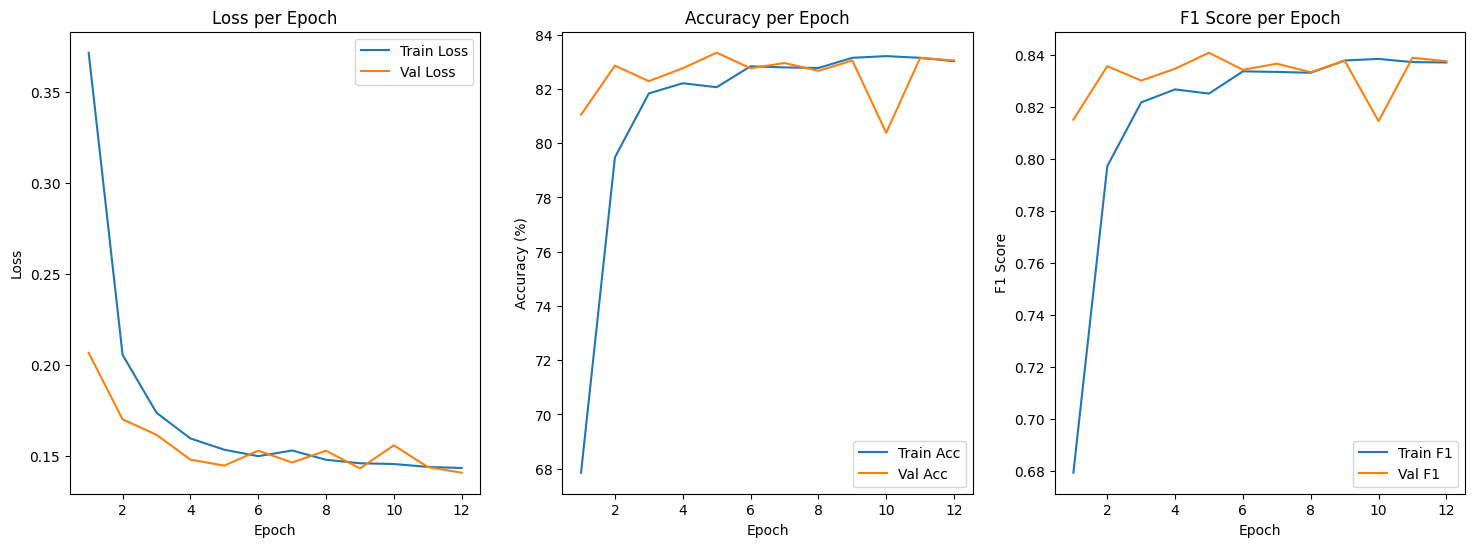

In [17]:
# Plot Training History
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracies, label='Train Acc')
plt.plot(epochs_range, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_scores, label='Train F1')
plt.plot(epochs_range, val_f1_scores, label='Val F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score per Epoch')
plt.legend()

plt.show()

In [18]:
# Test Evaluation
all_preds, all_labels = [], []

with torch.no_grad():
    for videos, keypoints, labels in test_loader:
        videos, keypoints, labels = videos.to(device), keypoints.to(device), labels.to(device)
        outputs = model(videos, keypoints)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("\nTest Set Performance:")
print(classification_report(all_labels, all_preds, target_names=actions))


Test Set Performance:
              precision    recall  f1-score   support

ball in hand       0.94      0.76      0.84        38
     dribble       1.00      0.76      0.86        37
   no_action       0.97      0.84      0.90        38
       shoot       0.64      1.00      0.78        37

    accuracy                           0.84       150
   macro avg       0.89      0.84      0.85       150
weighted avg       0.89      0.84      0.85       150



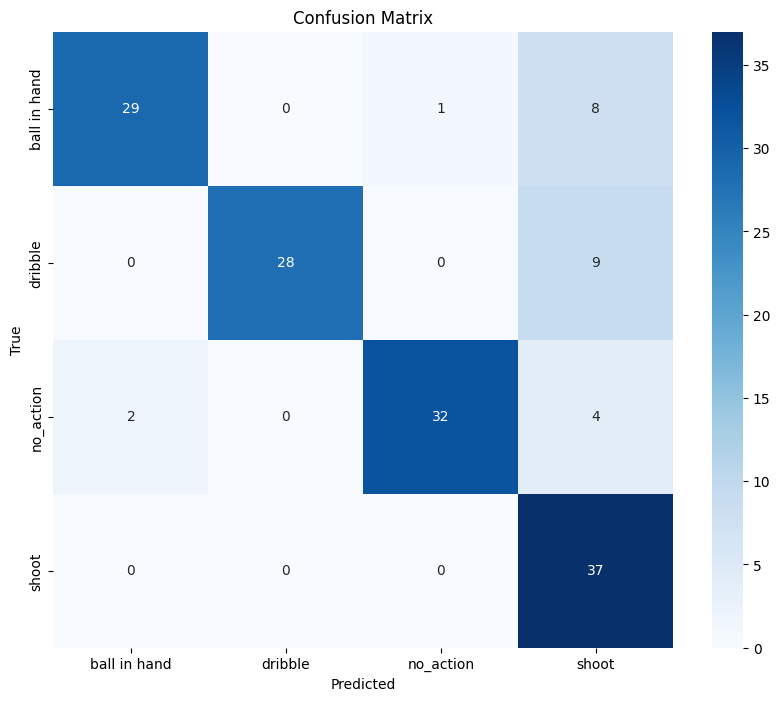

In [19]:
# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()